## Mean locust presence in croplands.

The goal of this notebook is to demonstrate how to leverage [MODIS Land Use](https://lpdaac.usgs.gov/products/mcd12q1v006/) for model insight generation.

This specific notebook merges modeled locus presence to MODIS cropland. This example will use the LC_Type1 layer in which layer 12 is cropland (see [IGBP land cover classification system](http://www.eomf.ou.edu/static/IGBP.pdf)).

The original `MODIS/Terra+Aqua Land Cover Type Yearly L3 Global 500 m SIN Grid` has been regridded using a `nearest` interpolation approach to 5 km resolution and clipped to Africa. The original data from MODIS can be [found here](https://jataware-world-modelers.s3.amazonaws.com/analytic-layers/MCD12Q1.006_500m_aid0001.nc) at the 500 m resolution.

First:

```
# download files from S3
wget https://jataware-world-modelers.s3.amazonaws.com/analytic-layers/gadm_0.zip
wget https://jataware-world-modelers.s3.amazonaws.com/analytic-layers/land-use-5km.nc
wget https://jataware-world-modelers.s3.amazonaws.com/analytic-layers/locust_sample.tif

# unzip gadm
unzip gadm_0.zip

# remove zip files
rm *.zip
```

The above shell commands will download and unzip a GADM shape file for countries of the world along with MODIS landuse data and a sample GeoTiff file based on the MaxHop model's output.

## Setup

You'll need to [install CDO](https://code.mpimet.mpg.de/projects/cdo/wiki#Installation-and-Supported-Platforms) before proceeding. Make sure to follow instructions for your specific OS.

### Requirements
```
numpy==1.20.3
geopandas==0.9.0
rioxarray==0.7.1
xarray==0.18.2
cdo==1.5.5
matplotlib==3.4.2
netCDF4==1.5.7
```

In [1]:
%matplotlib inline

In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import rioxarray as rxr
import xarray as xr

from cdo import * 
import os
os.environ['HDF5_DISABLE_VERSION_CHECK'] = "1"

cdo = Cdo()
cdo.debug = False

### Load geotif model of locust presence.

In [3]:
model_output = rxr.open_rasterio("locust_sample.tif", masked=True)
model_output = model_output.rio.write_crs(4326)
model_output = model_output.to_dataset('band')
model_output = model_output.rename({1: 'maxent'})

<xarray.Dataset>
Dimensions:      (y: 138, x: 180)
Coordinates:
  * x            (x) float64 33.03 33.11 33.2 33.28 ... 47.69 47.77 47.85 47.94
  * y            (y) float64 14.86 14.77 14.69 14.61 ... 3.696 3.613 3.53 3.447
    spatial_ref  int64 0
Data variables:
    maxent       (y, x) float32 ...
Attributes:
    STATISTICS_MAXIMUM:  0.92106811773334
    STATISTICS_MEAN:     0.39329051393139
    STATISTICS_MINIMUM:  0.022385184898966
    STATISTICS_STDDEV:   0.25825588082243
    scale_factor:        1.0
    add_offset:          0.0

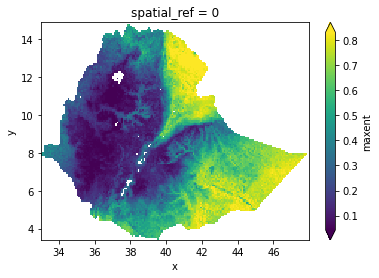

In [4]:
model_output.maxent.plot(robust=True)

### Load MODIS land use dataset. 

In [5]:
modis = xr.open_dataset('land-use-5km.nc',decode_coords="all")
modis = modis.rio.write_crs(4326)

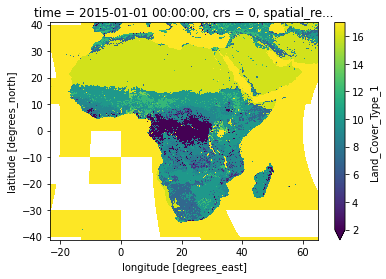

In [6]:
modis\
    .isel(time=0)\
    ['LC_Type1']\
    .plot(robust=True)

### Load GADM to get geometries of the country of interest.

In [7]:
shapefile = 'gadm_0/gadm36_0.shp'
sf = gpd.read_file(shapefile)
sf.head()

,GID_0,NAME_0,geometry
0,ABW,Aruba,"POLYGON ((-69.97820 12.46986, -69.97847 12.469..."
1,AFG,Afghanistan,"POLYGON ((68.52644 31.75435, 68.53852 31.75457..."
2,AGO,Angola,"MULTIPOLYGON (((11.73347 -16.67255, 11.73347 -..."
3,AIA,Anguilla,"MULTIPOLYGON (((-63.42375 18.58903, -63.42375 ..."
4,ALA,Åland,"MULTIPOLYGON (((21.32195 59.74986, 21.32195 59..."


In [8]:
countries = ['Ethiopia']
countries_shp = sf[sf['NAME_0'].isin(countries)]

### Clip MODIS to Ethiopia

In [9]:
modis_c = modis.rio.clip(countries_shp.geometry)

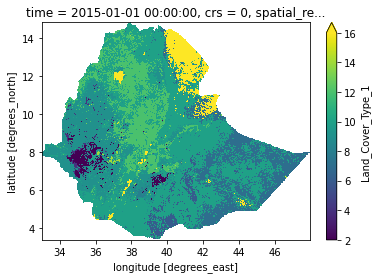

In [10]:
modis_c\
    .isel(time=0)\
    ['LC_Type1']\
    .plot(robust=True)

### Clip Model Output to Ethiopia

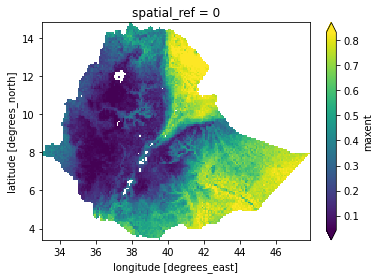

In [11]:
model_output_c = model_output.rio.clip(countries_shp.geometry)
model_output_c.maxent.plot(robust=True)

### Regrid MODIS to match model output

Use a nearest interpolation method since MODIS has categorical variables (land cover). This step uses the clipped
models saved as NetCDF files.

In [12]:
modis_c.to_netcdf('modis_tmp.nc')
model_output_c.to_netcdf('sample_tmp.nc')

In [13]:
modis_c_regrid = cdo.remapnn("sample_tmp.nc", input="modis_tmp.nc", options='-f nc', returnXDataset = True)

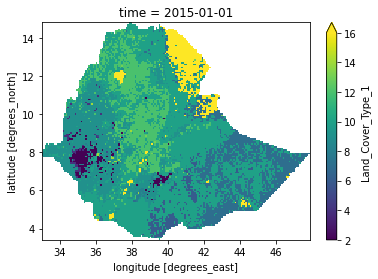

In [14]:
modis_c_regrid\
    .isel(time=0)\
    ['LC_Type1']\
    .plot(robust=True)

### Merge the regrided country-specific modis data to the country-specific  model_output

We can select any of the 5 available years from MODIS. You can access them with `modis_c_regrid.time`. Here we select the last (`2019`).

In [15]:
merged = xr.merge([modis_c_regrid.isel(time=4), model_output_c])

### Plot maxent for Croplands

Here we filter the locust predictions for only the land cover type of `Croplands`. There are 17 land cover categories in MODIS (for land cover type 1):

```
Evergreen_Needleleaf_Forests
Evergreen_Broadleaf_Forests
Deciduous_Needleleaf_Forests
Deciduous_Broadleaf_Forests
Mixed_Forests
Closed_Shrublands
Open_Shrublands
Woody_Savannas
Savannas
Grasslands
Permanent_Wetlands
Croplands
Urban_and_Built_up_Lands
Cropland_Natural_Vegetation_Mosaics
Permanent_Snow_and_Ice
Barren
Water_Bodies
Unclassified
```

You can access the actual grid value for each of these by accessing the attribute. For example `modis.LC_Type1.Croplands` returns `12` which is the Croplands value. 

See [IGBP Land Cover Classification System](http://www.eomf.ou.edu/static/IGBP.pdf) for more.

In [16]:
merged_crop = merged.where(merged.LC_Type1 == modis.LC_Type1.Croplands)

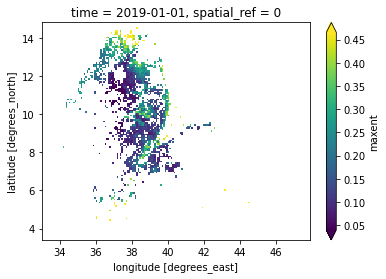

In [17]:
merged_crop['maxent'].plot(robust=True)

### Write the merged data set of time, x, y, maxent for Croplands to csv

We can greatly reduce the amount of data points by converting this to a CSV since the filtered CSV does not store the entire grid, just the cropland points.

Alternatively, this could be written back as a geotiff with `merged_crop.rio.to_raster` or a netcdf with `merged_crop.to_netcdf`

In [18]:
df = merged_crop.to_dataframe()
df = df[ df['maxent'] > 0]
df=df[['time', 'maxent']]
df.to_csv("ethiopia_maxent_croplands.csv")